In [130]:
# Load the packages needed for this part
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
import numpy as np

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

import pyspark
from pyspark.ml import feature, regression, Pipeline
from pyspark.sql import functions as fn, Row
from pyspark import sql

import matplotlib.pyplot as plt
import pandas as pd

# Servo data analysis

```console
1. Title: Servo Data

2. Sources
   (a) Created by: Karl Ulrich (MIT) in 1986
   (b) Donor: Ross Quinlan
   (c) Date: May 1993

3. Past Usage:

   1.  Quinlan, J.R., "Learning with continuous classes", Proc. 5th Australian
       Joint Conference on AI (eds A. Adams and L. Sterling), Singapore: World
       Scientific, 1992
 
   2.  Quinlan, J.R., "Combining instance-based and model-based learning",
       Proc. ML'93 (ed P.E. Utgoff), San Mateo: Morgan Kaufmann 1993
 
       Results on 10-way cross-validation:
 
       Method			Average		Relative
       ------			 |Err|		 Error
 				-------		--------
 
       Guessing mean		  1.15		  1.00
       Instance-based		   .52		   .26
       Regression		   .86		   .49
       Model trees		   .45		   .29
       Neural nets (G. Hinton)	   .30		   .11
       Regression+instances	   .48		   .20
       Model trees+instances	   .30		   .17
       NN+instances		   .29		   .11
 
4. Relevant Information:

   Ross Quinlan:

   This data was given to me by Karl Ulrich at MIT in 1986.  I didn't 
   record his description at the time, but here's his subsequent (1992) 
   recollection:
 
     "I seem to remember that the data was from a simulation of a servo
     system involving a servo amplifier, a motor, a lead screw/nut, and a
     sliding carriage of some sort.  It may have been on of the
     translational axes of a robot on the 9th floor of the AI lab.  In any
     case, the output value is almost certainly a rise time, or the time
     required for the system to respond to a step change in a position set
     point."
 
   (Quinlan, ML'93)

   "This is an interesting collection of data provided by Karl 
    Ulrich.  It covers an extremely non-linear phenomenon - predicting the 
    rise time of a servomechanism in terms of two (continuous) gain settings
    and two (discrete) choices of mechanical linkages."

5. Number of Instances: 167

6. Number of Attributes: 4 + numeric class attribute

7. Attribute information:

   1. motor: A,B,C,D,E
   2. screw: A,B,C,D,E
   3. pgain: 3,4,5,6
   4. vgain: 1,2,3,4,5
   5. class: 0.13 to 7.10

8. Missing Attribute Values: None
```

In [131]:
# Load the data
servo_df = spark.createDataFrame(pd.read_csv('/datasets/servo.data', 
            sep=',', 
            header=None,
            names=['motor', 'screw', 'pgain', 'vgain', 'rise_time']))

# 1. Explore the data

With big data, datasets can be too big to bring them into the Spark client. However, we can use the `limit` method of a dataframe to limit the number of rows to bring as a Pandas dataframe

Create a dataframe `servo_sample_df` with the first 20 rows of `servo_df`

In [132]:
# create `servo_sample_df`
servo_sample_df = servo_df.limit(20)

#raise NotImplementedError()

In [133]:
# 2 pts - right number of rows
np.testing.assert_equal(servo_sample_df.count(), 20)

Below, transform `servo_sample_df` into a Pandas dataframe and do a scatter plot of `pgain` vs `rise_time`

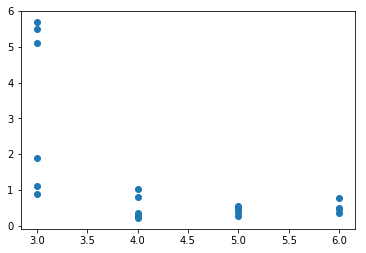

In [134]:
servo_sample_df = servo_sample_df.toPandas()
x=servo_sample_df.pgain
y=servo_sample_df.rise_time
plt.scatter(x,y)
plt.show()
#raise NotImplementedError()

 Below, transform `servo_sample_df` into a Pandas dataframe and do a scatter plot of `vgain` vs `rise_time`

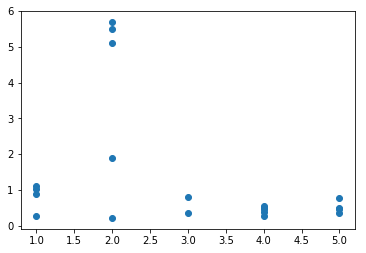

In [135]:
#servo_sample_df is already a pandas dataframe
#servo_sample_df = servo_sample_df.toPandas()
x=servo_sample_df.vgain
y=servo_sample_df.rise_time
plt.scatter(x,y)
plt.show()

#raise NotImplementedError()

## Perform correlations between vgain-rise time, pgain-rise time, and vgain-pgain

Create a `servo_corr_df` dataframe that contains the correlations between `vgain` and `rise_time` as a column `corr_vgain_rise_time`, between `pgain` and `rise_time` as `corr_pgain_rise_time`, and `vgain` and `pgain` as `corr_vgain_pgain`.

In [145]:

col = ["corr_vgain_rise_time","corr_pgain_rise_time","corr_vgain_pgain"]
val = [(float(servo_df.stat.corr('vgain','rise_time')),float(servo_df.stat.corr('pgain','rise_time')),float(servo_df.stat.corr('pgain','vgain')))]
servo_corr_df = spark.createDataFrame(val, col)


## Compute mean rise_time for different motors and screws

Create `motor_rise_time_df` with the column `motor` and `avg_rise_time`, where `avg_rise_time` is the average rise time for a motor. Sort the resulting dataframe from highest to lowest average rise time.

In [149]:
motor_rise_time_df = servo_df.\
    groupBy('motor').\
    agg(fn.avg('rise_time').alias("avg_rise_time")).sort(fn.col("avg_rise_time").desc())

#raise NotImplementedError()

Create `screw_rise_time_df` with the column `screw` and `avg_rise_time` sorted from highest to lowest average rise time.

In [151]:
screw_rise_time_df = servo_df.\
    groupBy('screw').\
    agg(fn.avg('rise_time').alias("avg_rise_time")).sort(fn.col("avg_rise_time").desc())


# Feature engineering

## Dummy variables for motors and screws
Create a dataframe `dummy_df` with columns `motor` and `screw` as dummy variables, and columns `vgain`, `pgain`, and `rise_time`. Use motor D and screw C as the baselines and name the dummy variables `motor_A` for motor `A` and so on. Follow a similar pattern for screw. The dataframe `dummy_df` should not contain the columns `motor` and `screw` but only their dummy variable representations. **All column types should be float or integer.**

In [153]:
# create dummy_df below
def amit(row):    
    #for row in servo_df.rdd.collect():
    ma=0
    mb = 0
    mc=0
    md=0
    me=0
    sa=0
    sb=0
    sc=0
    sd=0
    se = 0

    if row.motor == "A":
        ma = 1
        #print("A")
    elif row.motor == "B":
        mb = 1
    elif row.motor == "C":
        mc = 1
    elif row.motor =="E":
        me = 1
    else:# row.motor == "D":
        ma=0
        mb=0
        mc=0
        me = 0


    if row.screw == "A":
        sa = 1
    elif row.screw == "B":
        sb = 1
    elif row.screw == "D":
        sd = 1
    elif row.screw == "E":
        se = 1
    else:# row.screw =="C":
        sa=0
        sb=0
        sd=0
        se = 0

    r = Row(motor_A=float(ma) ,motor_B=float(mb) ,motor_C=float(mc),motor_E=float(me),screw_A=float(sa),screw_B=float(sb),screw_D=float(sd),screw_E=float(se), vgain = float(row.vgain),pgain=float(row.pgain),rise_time = float(row.rise_time))
    return(r)
dummy_df = spark.createDataFrame(servo_df.rdd.map(amit))
#raise NotImplementedError()

# Model comparison
Use the splits below to fit, validate, and estimate the generalization error of your models. 

In [155]:
training_df, validation_df, testing_df = dummy_df.randomSplit([0.6, 0.3, 0.1], seed=0)
print("# points in training: ", training_df.count())
print("# points in validation: ", validation_df.count())
print("# points in testing: ", testing_df.count())

# points in training:  102
# points in validation:  50
# points in testing:  15


## Propose three regression models

In the next section, you will choose the best model to explain the data in `servo_df`. Select the right split of the data for the right step of the process (i.e., training, validation, and testing)

### Model 1: Fit model with only `pgain`

Create a pipeline that takes *pgain* as a feature to predict *rise time* and fits a linear regression model. You should start your pipeline by taking the appropriate column or columns from `dummy_df` in which the raw feature `pgain` may or may not have been feature engineered. Assign the fit pipeline transformer to `pipe_model1`. Your pipeline must have one vector assembler followed by a linear regression.

In [156]:
training_df

DataFrame[motor_A: double, motor_B: double, motor_C: double, motor_E: double, pgain: double, rise_time: double, screw_A: double, screw_B: double, screw_D: double, screw_E: double, vgain: double]

In [157]:
# create `pipe_model1` below
model1 = Pipeline(stages=[feature.VectorAssembler(inputCols=['pgain'],
                                        outputCol='features1'),
                 regression.LinearRegression(labelCol='rise_time', featuresCol='features1')])
pipe_model1 = model1.fit(training_df)
pipe_model1df = pipe_model1.transform(validation_df).select("rise_time","prediction")


### Model 2: Fit model with only `vgain`

Follow the same idea as above and create a pipeline transformer `pipe_model2`

In [159]:

model2 = Pipeline(stages=[feature.VectorAssembler(inputCols=['vgain'],
                                        outputCol='features2'),
                 regression.LinearRegression(labelCol='rise_time', featuresCol='features2')])
pipe_model2 = model2.fit(training_df)
pipe_model2df = pipe_model2.transform(validation_df).select("rise_time","prediction")


### Model 3: Fit model with only motor, screw, pgain, and vgain

Follow the same idea as above and create a pipeline transformer `pipe_model3`. Remember that some features have been feature engineered. In particular, use the transformed columns in the order: motor, screw, pgain, and vgain. Choose the columns from `dummy_df` appropriately.

In [161]:
# create `pipe_model2` below
model3 = Pipeline(stages=[feature.VectorAssembler(inputCols=['vgain','pgain','motor_A','motor_B','motor_C','motor_E','screw_A','screw_B','screw_D','screw_E'],
                                        outputCol='features3'),
                 regression.LinearRegression(labelCol='rise_time', featuresCol='features3')])
pipe_model3 = model3.fit(training_df)
pipe_model3df = pipe_model3.transform(validation_df).select("rise_time","prediction")


# Compare models

### Estimate RMSE on validation data for the three models

Create three dataframes `rmse1_df`, `rmse2_df`, and `rmse3_df` for models 1, 2, and 3, respectively, with only with column `rmse`

In [163]:
# create rmse1_df, rmse2_df, and rmse3_df dataframes below
rmse1_df = pipe_model1df.\
            select(fn.sqrt(fn.sum(fn.pow(fn.col("prediction")-fn.col("rise_time"),fn.lit(2)))/fn.count("rise_time")).alias("rmse"))
rmse2_df = pipe_model2df.\
            select(fn.sqrt(fn.sum(fn.pow(fn.col("prediction")-fn.col("rise_time"),fn.lit(2)))/fn.count("rise_time")).alias("rmse"))
rmse3_df = pipe_model3df.\
            select(fn.sqrt(fn.sum(fn.pow(fn.col("prediction")-fn.col("rise_time"),fn.lit(2)))/fn.count("rise_time")).alias("rmse"))

#raise NotImplementedError()

In [164]:
# display the answers here
rmse1_df.show()
rmse2_df.show()
rmse3_df.show()

+------------------+
|              rmse|
+------------------+
|1.1001239188393122|
+------------------+

+------------------+
|              rmse|
+------------------+
|1.3414284478346097|
+------------------+

+-----------------+
|             rmse|
+-----------------+
|1.100639599843575|
+-----------------+



Assign the best cross validated model to a variable `best_model` below

In [166]:
# assign best model (the best pipeline transformer) to a variable best_model below
best_model = model1.fit(training_df)



### Estimate generalization performance with RMSE

Create a variable `rmse_best_df` that contains the RMSE of the best model on testing data

In [168]:
# create rmse_best_df
pipe_model1df = pipe_model1.transform(testing_df).select("rise_time","prediction")
rmse_best_df = pipe_model1df.\
            select(fn.sqrt(fn.sum(fn.pow(fn.col("prediction")-fn.col("rise_time"),fn.lit(2)))/fn.count("rise_time")).alias("rmse"))



In [170]:

rmse_best_df.show()


+------------------+
|              rmse|
+------------------+
|0.9457118282838648|
+------------------+



# Do inference with best model

Assume that model 3 is the best one. Redefine a new pipeline for this model called `pipe_model_best` and fit it to the **entire training data** (all of `dummy_df`).

In [171]:
# create `pipe_model_best` below
model3best = Pipeline(stages=[feature.VectorAssembler(inputCols=['vgain','pgain','motor_A','motor_B','motor_C','motor_E','screw_A','screw_B','screw_D','screw_E'],
                                        outputCol='features'),
                 regression.LinearRegression(labelCol='rise_time', featuresCol='features')])
pipe_model_best = model3.fit(dummy_df)
pipe_model3bestdf = pipe_model_best.transform(validation_df).select("rise_time","prediction")
#raise NotImplementedError()

Assume that all features on `dummy_df` were comparable (i.e., standardized). Taking motor D and screw C as the baseline, what are the top 2 most important features for *increasing rise time* and the top 2 most important features for *decreasing rise time*? 

In [173]:
print("Coefficients: \n" + str(pipe_model_best.stages[1].coefficients))
print("Intercept: " + str(pipe_model_best.stages[1].intercept))

Coefficients: 
[0.5669977447386758,-1.6435283526061404,1.4302994488954588,1.3511311477843475,1.1637314607637186,0.7438666491702665,1.0825045850585815,0.36178443690543416,-0.12295757537582248,-0.0831835928359515]
Intercept: 5.4432813052406495


In [174]:

new_df = dummy_df.\
        agg(fn.corr("pgain","rise_time"),fn.corr("vgain","rise_time"),fn.corr("motor_A","rise_time"),fn.corr("motor_B","rise_time"),\
           fn.corr("motor_C","rise_time"),fn.corr("motor_E","rise_time"),fn.corr("screw_A","rise_time"),fn.corr("screw_B","rise_time"),\
           fn.corr("screw_D","rise_time"),fn.corr("screw_D","rise_time"))


In [175]:
new_df.show()

+----------------------+----------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+
|corr(pgain, rise_time)|corr(vgain, rise_time)|corr(motor_A, rise_time)|corr(motor_B, rise_time)|corr(motor_C, rise_time)|corr(motor_E, rise_time)|corr(screw_A, rise_time)|corr(screw_B, rise_time)|corr(screw_D, rise_time)|corr(screw_D, rise_time)|
+----------------------+----------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+
|   -0.5981287119612231|   -0.3643826662691459|     0.12521067045190243|     0.09852069958156003|    -0.04895766773884526|    -0.07813112635429018|     0.14119089474847538|    7.464582106268775E-4|    -0.06875338789737075|    -0.06875338789737075|
+-------

Top 2 most important features for increasing rise time(with highest positive coefficient)  = motorA,motorB
Top 2 most important features for decreasing rise time(with highest negative coefficient) = pgain,screwD
